### Treinando os modelos LightGBM Regressor (LGBM) e Multi-Layer Perceptron (MLP) - Regressor com sklearn:

Bibliotecas utilizadas:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

Importando o dataset:

In [2]:
all_players_data = pd.read_csv("all_players_data.csv")

In [3]:
all_players_data.head()

,player_id,name,last_season,current_club_id,player_code,country_of_citizenship,date_of_birth,sub_position,position,foot,...,assists_2024,avg_minutes_2024,proporcao_titular,vezes_capitao_2024,player_preferred_formation,market_value_2019,market_value_2020,market_value_2021,market_value_2022,market_value_2023
0,3333,James Milner,2024,1237,james-milner,England,1986-01-04,Central Midfield,Midfield,right,...,0.0,59.000000,0.666667,0.0,4-2-3-1,12000000.0,5000000.0,2000000.0,2000000.0,1000000.0
1,5336,Anastasios Tsokanis,2024,60949,anastasios-tsokanis,Greece,1991-05-02,Defensive Midfield,Midfield,left,...,0.0,58.058824,0.428571,3.0,4-2-3-1,400000.0,350000.0,350000.0,450000.0,450000.0
2,7161,Jonas Hofmann,2024,15,jonas-hofmann,Germany,1992-07-14,Attacking Midfield,Midfield,right,...,5.0,54.967742,0.545455,0.0,4-2-3-1,9000000.0,14000000.0,16000000.0,13000000.0,13000000.0
3,7825,Pepe Reina,2024,1047,pepe-reina,Spain,1982-08-31,Goalkeeper,Goalkeeper,right,...,0.0,92.000000,0.285714,0.0,4-3-3 Attacking,800000.0,800000.0,800000.0,700000.0,700000.0
4,11530,Lionel Carole,2024,3205,lionel-carole,France,1991-04-12,Left-Back,Defender,left,...,1.0,80.000000,0.900000,0.0,4-2-3-1,2500000.0,2000000.0,2000000.0,1700000.0,850000.0


Treinamento:

Utilizou-se a partição train_test_split(), com test_size = 0.3 e random_state = 42.

In [4]:
def print_cv_results(name, results):
    print(f"\nResultados - {name}")
    print(f"R² (média): {np.mean(results['test_r2']):.4f}")
    print(f"RMSE (média): {-np.mean(results['test_neg_root_mean_squared_error']):.2f}")
    print(f"MAE (média): {-np.mean(results['test_neg_mean_absolute_error']):.2f}")

In [5]:
target = 'market_value_in_eur'

columns_to_exclude = [
    'player_id', 'name', 'player_code', 'date_of_birth', 'current_club_name',
    'market_value_in_eur'
]

X = all_players_data.drop(columns = columns_to_exclude)
y = all_players_data[target]

categorical_cols = X.select_dtypes(include = ['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Preprocessor:

In [6]:
preprocessor = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols)],
    remainder = 'passthrough'
)

LightGBM Regressor (LGBM):

In [7]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42, verbose=-1))
])

In [8]:
lgbm_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__learning_rate': [0.05, 0.1]
}

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

lgbm_grid = GridSearchCV(lgbm_pipeline, lgbm_param_grid, cv=5, scoring='r2', n_jobs=-1)
lgbm_grid.fit(X, y)

print("Melhores parâmetros LGBM:", lgbm_grid.best_params_)

Melhores parâmetros LGBM: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 200}


Multi-Layer Perceptron (MLP) - Regressor com sklearn:

In [10]:
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(max_iter=500, random_state=42))
])

In [11]:
mlp_param_grid = {
    'model__hidden_layer_sizes': [(100,), (100, 50)],
    'model__alpha': [0.0001, 0.001],
    'model__learning_rate_init': [0.001, 0.01]
}

In [12]:
mlp_grid = GridSearchCV(mlp_pipeline, mlp_param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
mlp_grid.fit(X, y)
print("Melhores parâmetros LGBM:", mlp_grid.best_params_)

Melhores parâmetros LGBM: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate_init': 0.001}


In [13]:
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

lgbm_results = cross_validate(lgbm_grid.best_estimator_, X, y, cv = 5, scoring = scoring, return_train_score = True)
mlp_results = cross_validate(mlp_grid.best_estimator_, X, y, cv = 5, scoring = scoring, return_train_score = True)

In [15]:
print_cv_results("LightGBM Regressor", lgbm_results)
print_cv_results("Multi-Layer Perceptron", mlp_results)


Resultados - LightGBM Regressor
R² (média): 0.7215
RMSE (média): 4484347.16
MAE (média): 1587040.59

Resultados - Multi-Layer Perceptron
R² (média): 0.8908
RMSE (média): 3134058.79
MAE (média): 1334623.31


In [16]:
results_df = pd.DataFrame({
    'Modelo': ['LightGBM Regressor'] * 5 + ['Multi-Layer Perceptron'] * 5,
    'R²': np.concatenate([lgbm_results['test_r2'], mlp_results['test_r2']]),
    'RMSE': -np.concatenate([lgbm_results['test_neg_root_mean_squared_error'], mlp_results['test_neg_root_mean_squared_error']]),
    'MAE': -np.concatenate([lgbm_results['test_neg_mean_absolute_error'], mlp_results['test_neg_mean_absolute_error']])
})

In [17]:
results_long = results_df.melt(id_vars = 'Modelo', var_name = 'Métrica', value_name = 'Valor')

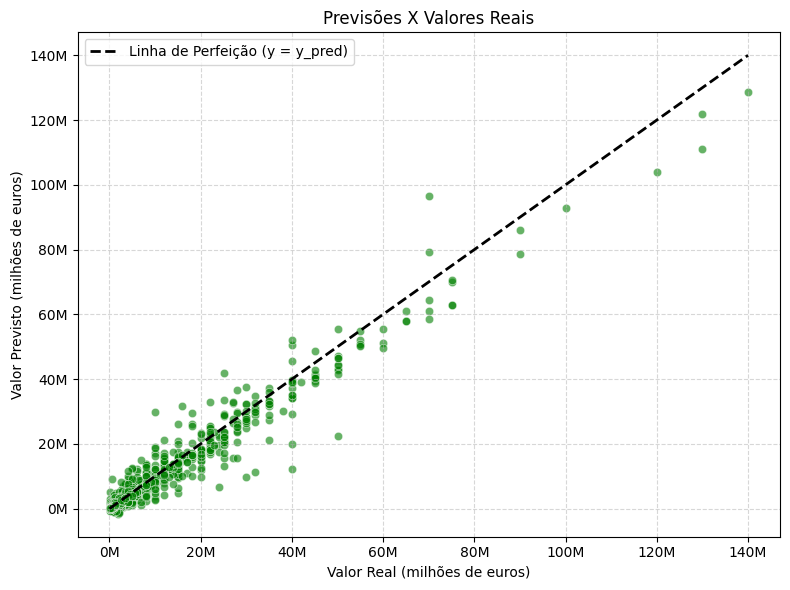

In [33]:
# Previsões com o modelo Multi-Layer Perceptron já treinado
y_pred = mlp_grid.predict(X_test)

# Converter valores para milhões
y_test_mil = y_test / 1e6
y_pred_mil = y_pred / 1e6

# Função para formatar os valores dos eixos como milhões
def milhões(x, pos):
    return f'{x:.0f}M'

formatter = FuncFormatter(milhões)

# Gráfico de dispersão
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test_mil, y = y_pred_mil, alpha = 0.6, color='green')

plt.plot([y_test_mil.min(), y_test_mil.max()],
         [y_test_mil.min(), y_test_mil.max()],
         color = 'black', lw = 2, linestyle = '--', label = 'Linha de Perfeição (y = y_pred)')

plt.title('Previsões X Valores Reais')
plt.xlabel('Valor Real (milhões de euros)')
plt.ylabel('Valor Previsto (milhões de euros)')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

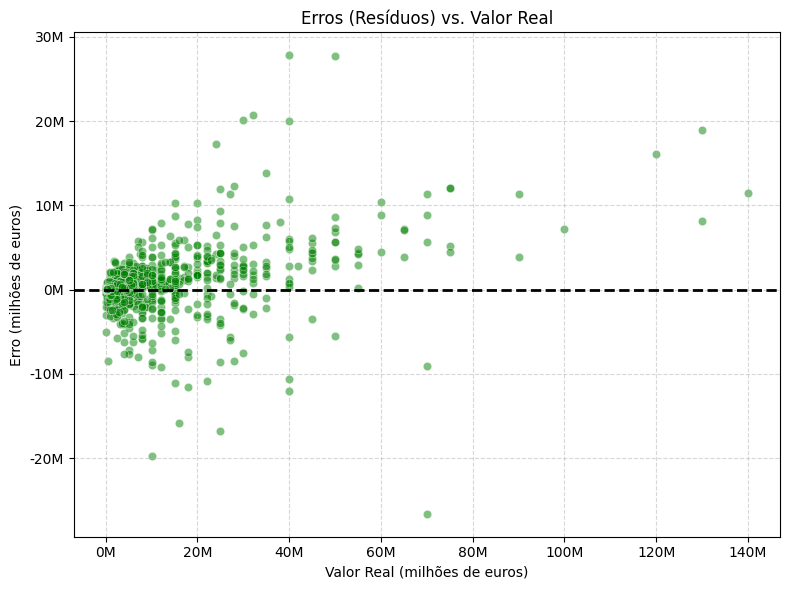

In [34]:
# Cálculo dos resíduos
residuals = y_test - y_pred

# Converter para milhões de euros
y_test_mil = y_test / 1e6
residuals_mil = residuals / 1e6

# Formatador de milhões
def milhões(x, pos):
    return f'{x:.0f}M'

formatter = FuncFormatter(milhões)

# Gráfico de resíduos
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test_mil, y = residuals_mil, alpha = 0.5, color = 'green')

plt.axhline(0, color = 'black', linestyle = '--', lw = 2)
plt.title('Erros (Resíduos) vs. Valor Real')
plt.xlabel('Valor Real (milhões de euros)')
plt.ylabel('Erro (milhões de euros)')
plt.grid(True, linestyle = '--', alpha = 0.5)

# Aplicar formatador nos eixos
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

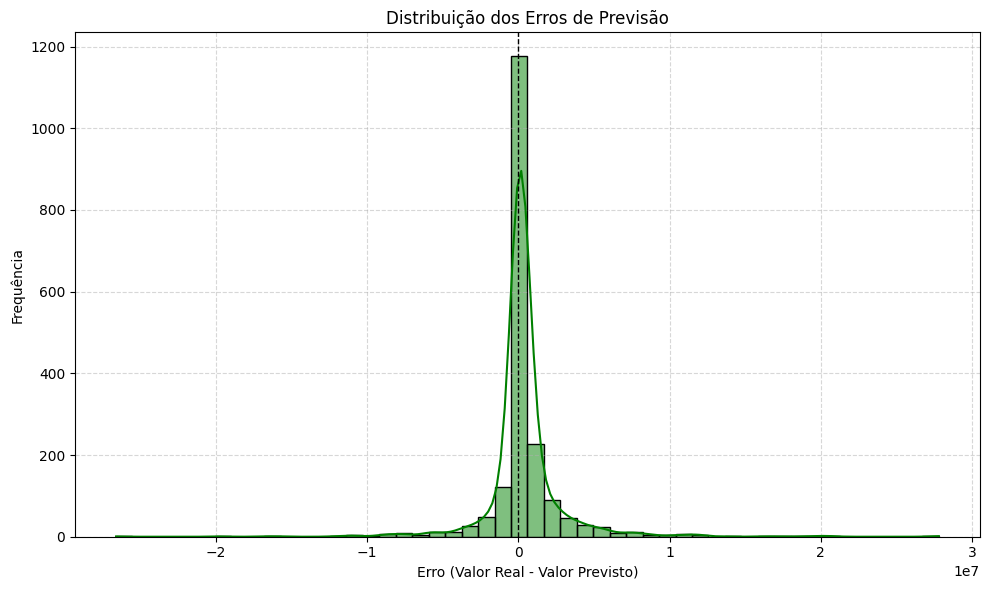

In [36]:
plt.figure(figsize = (10, 6))
sns.histplot(residuals, bins = 50, kde = True, color = 'green')

plt.axvline(0, color = 'black', linestyle = '--', lw = 1)
plt.title('Distribuição dos Erros de Previsão')
plt.xlabel('Erro (Valor Real - Valor Previsto)')
plt.ylabel('Frequência')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()